<a href="https://colab.research.google.com/github/shreyjain26/Image_Segmentation/blob/main/Unet_segmentation_fair.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Imports

In [ ]:
import tensorflow as tf
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt

dataset, info = tfds.load('oxford_iiit_pet:3.*.*', with_info = True)
info

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/2 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/3680 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/oxford_iiit_pet/3.2.0.incompleteS26B62/oxford_iiit_pet-train.tfrecord*...:…

Generating test examples...:   0%|          | 0/3669 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/oxford_iiit_pet/3.2.0.incompleteS26B62/oxford_iiit_pet-test.tfrecord*...: …

Dataset oxford_iiit_pet downloaded and prepared to /root/tensorflow_datasets/oxford_iiit_pet/3.2.0. Subsequent calls will reuse this data.


tfds.core.DatasetInfo(
    name='oxford_iiit_pet',
    full_name='oxford_iiit_pet/3.2.0',
    description="""
    The Oxford-IIIT pet dataset is a 37 category pet image dataset with roughly 200
    images for each class. The images have large variations in scale, pose and
    lighting. All images have an associated ground truth annotation of breed.
    """,
    homepage='http://www.robots.ox.ac.uk/~vgg/data/pets/',
    data_path=PosixGPath('/tmp/tmp4wipuqs6tfds'),
    file_format=tfrecord,
    download_size=773.52 MiB,
    dataset_size=774.69 MiB,
    features=FeaturesDict({
        'file_name': Text(shape=(), dtype=string),
        'image': Image(shape=(None, None, 3), dtype=uint8),
        'label': ClassLabel(shape=(), dtype=int64, num_classes=37),
        'segmentation_mask': Image(shape=(None, None, 1), dtype=uint8),
        'species': ClassLabel(shape=(), dtype=int64, num_classes=2),
    }),
    supervised_keys=('image', 'label'),
    disable_shuffling=False,
    splits={
        

In [ ]:
x = tfds.as_dataframe(dataset['train'].take(2), info)
y = tfds.as_dataframe(dataset['test'].take(2), info)
x.info()

<class 'tensorflow_datasets.core.as_dataframe.StyledDataFrame'>
RangeIndex: 2 entries, 0 to 1
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   file_name          2 non-null      object
 1   image              2 non-null      object
 2   label              2 non-null      int64 
 3   segmentation_mask  2 non-null      object
 4   species            2 non-null      int64 
dtypes: int64(2), object(3)
memory usage: 208.0+ bytes


,file_name,image,label,segmentation_mask,species
0,Sphynx_158.jpg,,33 (Sphynx),,0 (Cat)
1,english_cocker_spaniel_135.jpg,,12 (english_cocker_spaniel),,1 (Dog)

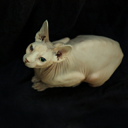
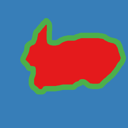
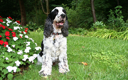
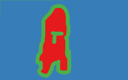

In [ ]:
x

,file_name,image,label,segmentation_mask,species
0,leonberger_73.jpg,,19 (leonberger),,1 (Dog)
1,Maine_Coon_231.jpg,,20 (Maine_Coon),,0 (Cat)

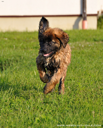
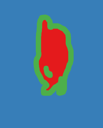
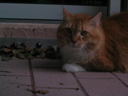
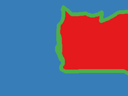

In [ ]:
y

#Preprocessing

In [ ]:
def normalize_img(image, mask):
  return tf.cast(image, tf.float32)/255.0 , mask-1      #Images are normalised to [0,1] and classes go from {1,2,3} -> {0,1,2}

In [ ]:
#Function to load the image according to our needs, includes -> resizing of the image and its true mask and along with normalization of the image using the function in above cell
def load_image(img):
  input_image = tf.image.resize(img['image'], (256, 256))
  input_mask = tf.image.resize(img['segmentation_mask'], (256, 256), method = tf.image.ResizeMethod.NEAREST_NEIGHBOR)

  return normalize_img(input_image, input_mask)

In [ ]:
train_images = dataset['train'].map(load_image, num_parallel_calls = tf.data.AUTOTUNE)
test_images = dataset['test'].map(load_image, num_parallel_calls = tf.data.AUTOTUNE)

In [ ]:
train_images

<ParallelMapDataset element_spec=(TensorSpec(shape=(256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(256, 256, 1), dtype=tf.uint8, name=None))>

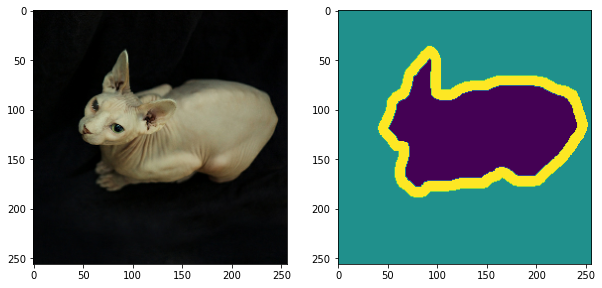

In [ ]:
img, mask = next(iter(train_images))
plt.figure(figsize = (10, 10))
plt.subplot(1,2,1)
plt.imshow(img)
plt.subplot(1,2,2)
plt.imshow(mask)

In [ ]:
img.shape, mask.shape, len(train_images), len(test_images)

(TensorShape([256, 256, 3]), TensorShape([256, 256, 1]), 3680, 3669)

Batching the datasets

In [ ]:
#Setting up Hyperparameters
INPUT_SHAPE = (256, 256, 3)
NUM_CLASSES = 3
BUFFER_SIZE = 500
BATCH_SIZE = 32

In [ ]:
train_batches = train_images.cache().shuffle(buffer_size = 500).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
test_batches = test_images.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

`cache()` : after the first time data is loaded, some of it will be saved in memory. This increases the speed of data loading next time.

`shuffle()`: This shuffles the images randomly

`batch(BATCH_SIZE)`: This clubs the images into batches of 32

`prefetch()`: When the gpu is running, some images are prefetched (set in line) for the next iteration. This helps to reduce the time between training of each batch as the next batch is ready to be run instantly.

cache and shuffle are not used in test because we do not want the model to remember the test images as the sole purpose is to evaluate the model. Likewise, there is no need to train.

In [ ]:
train_batches

<PrefetchDataset element_spec=(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 256, 256, 1), dtype=tf.uint8, name=None))>

In the other notebook where I was simply understanding what each line does and its importance, I did not use batches. Consequently, the images I had were of shape (256, 256, 3). This helped me to understand many properties of tensors by running into countless errors. Here, by creating batches, I do not have to add extra dimension.

In [ ]:
def display(display_list):
  plt.figure(figsize=(15, 15))

  title = ['Input Image', 'True Mask', 'Predicted Mask']

  for i in range(len(display_list)):
    plt.subplot(1, len(display_list), i+1)
    plt.title(title[i])
    plt.imshow(tf.keras.utils.array_to_img(display_list[i]))
    plt.axis('off')
  plt.show()

(32, 256, 256, 3) (32, 256, 256, 1)
(256, 256, 3) (256, 256, 1)


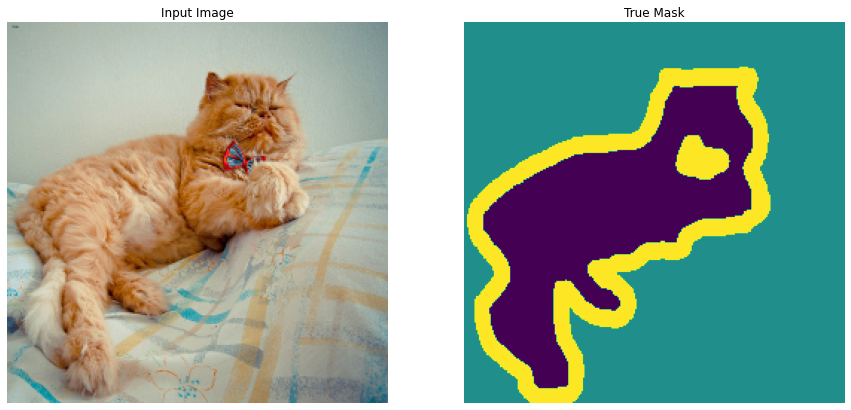

(32, 256, 256, 3) (32, 256, 256, 1)
(256, 256, 3) (256, 256, 1)


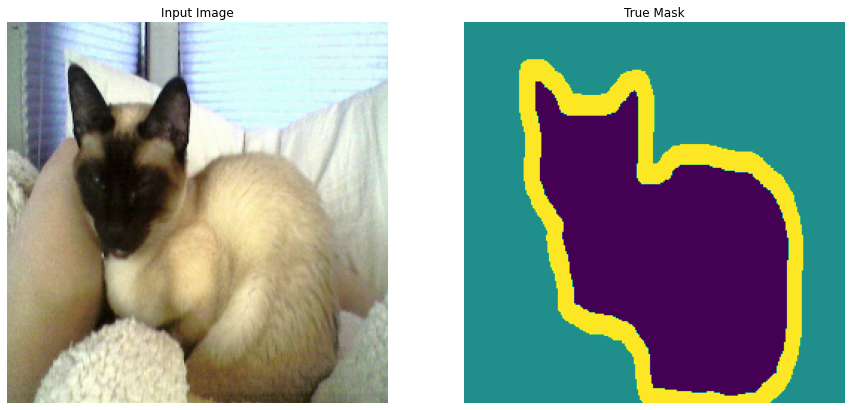

In [ ]:
for image, mask in train_batches.take(2):
  print(image.shape, mask.shape)          #To see that unlike before where I turned the dataset into iterable and picked up the image direcly, it picks up batches of images and masks
  print(image[0].shape, mask[0].shape)
  display([image[0], mask[0]])

#Model

In [ ]:
def conv_block(input, filters: int, drop_out: int):
  x = tf.keras.layers.Conv2D(filters, 3, padding = "same",  activation = "relu")(input)
  x = tf.keras.layers.Dropout(drop_out)(x)
  x = tf.keras.layers.Conv2D(filters, 3, padding = "same",  activation = "relu")(x)
  return x

In [ ]:
def encoder(input, filters: int, drop_out: int):
  x = conv_block(input, filters, drop_out)
  p = tf.keras.layers.MaxPool2D(2)(x)
  return x, p

In [ ]:
def decoder(input, skip_features, filters: int, drop_out: int):
  x = tf.keras.layers.Conv2DTranspose(filters, kernel_size = 2, strides = 2, padding = 'same')(input)
  x = tf.keras.layers.concatenate([x, skip_features])
  x = conv_block(x, filters, drop_out)
  return x

In [ ]:
def Unet(input_shape, num_classes: int):
  inputs = tf.keras.layers.Input(input_shape)

  s1, p1 = encoder(inputs, 64, 0.1)
  s2, p2 = encoder(p1, 128, 0.1)
  s3, p3 = encoder(p2, 256, 0.2)
  s4, p4 = encoder(p3, 512, 0.2)

  bottle_neck = conv_block(p4, 1024, 0.3)

  d1 = decoder(bottle_neck, s4, 512, 0.2)
  d2 = decoder(d1, s3, 256, 0.2)
  d3 = decoder(d2, s2, 128, 0.1)
  d4 = decoder(d3, s1, 64, 0.1)

  outputs = tf.keras.layers.Conv2D(filters = num_classes, kernel_size = 1, padding = 'same', activation = 'softmax')(d4)

  return tf.keras.Model(inputs = [inputs], outputs = [outputs])

In [ ]:
model = Unet(INPUT_SHAPE, NUM_CLASSES)
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 256, 256, 64  1792        ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 dropout (Dropout)              (None, 256, 256, 64  0           ['conv2d[0][0]']                 
                                )                                                             

In [ ]:
model.compile(optimizer = 'adam', loss = 'sparse_categorical_crossentropy', metrics = ['accuracy'])

In [ ]:
def create_mask(pred_mask):
  pred_mask = tf.math.argmax(pred_mask, axis=-1)
  pred_mask = pred_mask[..., tf.newaxis]
  return pred_mask[0]

def show_predictions(dataset=None, num=1):
  if dataset:
    for image2, mask2 in dataset.take(num):
      pred_mask = model.predict(image2)
      display([image2[0], mask2[0], create_mask(pred_mask)])
  else:
    display([img, mask,
             create_mask(model.predict(img[tf.newaxis, ...]))])

In [ ]:
model.fit(train_batches, epochs = 5)

Epoch 1/5
115/115 [==============================] - 238s 2s/step - loss: 0.9435 - accuracy: 0.5805
Epoch 2/5
115/115 [==============================] - 208s 2s/step - loss: 0.7995 - accuracy: 0.6328
Epoch 3/5
115/115 [==============================] - 206s 2s/step - loss: 0.6928 - accuracy: 0.7204
Epoch 4/5
115/115 [==============================] - 206s 2s/step - loss: 0.6845 - accuracy: 0.7246
Epoch 5/5
115/115 [==============================] - 209s 2s/step - loss: 0.6409 - accuracy: 0.7438


1/1 [==============================] - 1s 1s/step


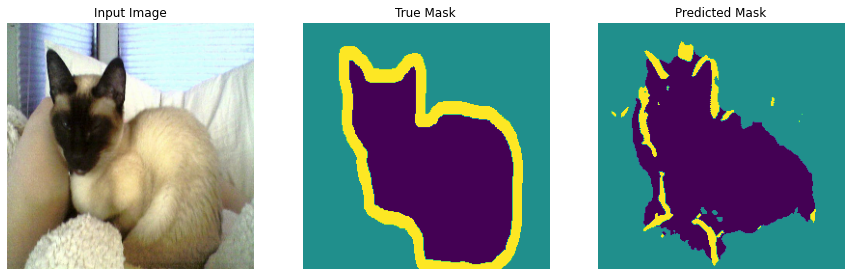

1/1 [==============================] - 0s 56ms/step


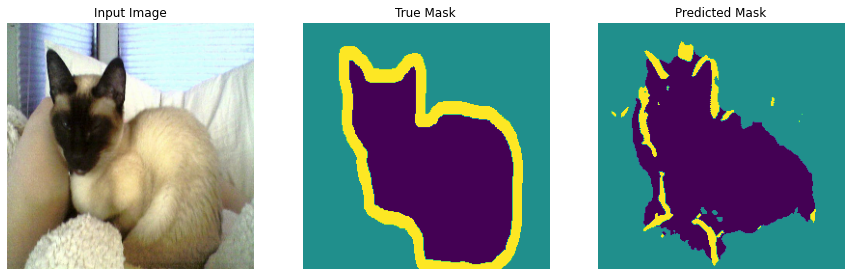

1/1 [==============================] - 0s 49ms/step


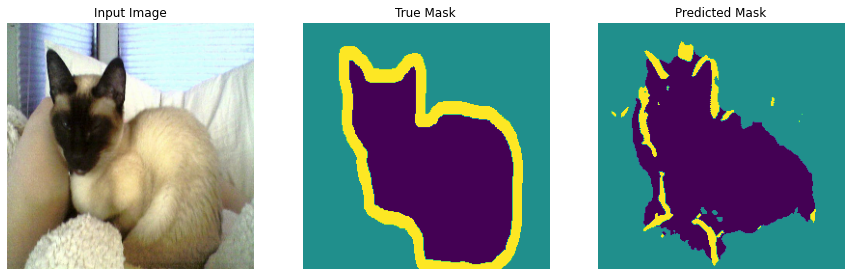

In [ ]:
show_predictions(test_batches, 3)

In [ ]:
model.fit(train_batches, epochs = 2)

Epoch 1/2
115/115 [==============================] - 207s 2s/step - loss: 0.5221 - accuracy: 0.7979
Epoch 2/2
115/115 [==============================] - 208s 2s/step - loss: 0.4595 - accuracy: 0.8235


1/1 [==============================] - 0s 57ms/step


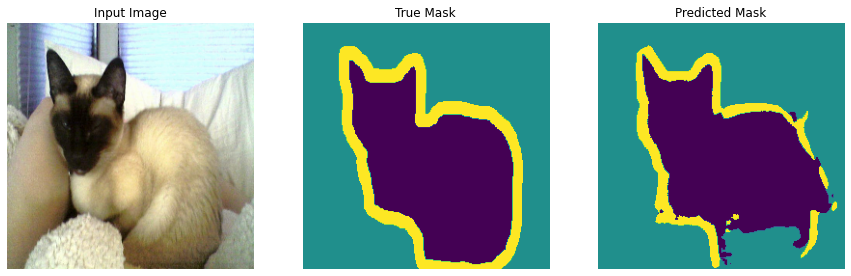

In [ ]:
show_predictions(test_batches)

In [ ]:
model.fit(train_batches, epochs = 5)

Epoch 1/5
115/115 [==============================] - 203s 2s/step - loss: 0.4274 - accuracy: 0.8354
Epoch 2/5
115/115 [==============================] - 205s 2s/step - loss: 0.3956 - accuracy: 0.8486
Epoch 3/5
115/115 [==============================] - 208s 2s/step - loss: 0.3700 - accuracy: 0.8584
Epoch 4/5
115/115 [==============================] - 206s 2s/step - loss: 0.3531 - accuracy: 0.8648
Epoch 5/5
115/115 [==============================] - 208s 2s/step - loss: 0.3365 - accuracy: 0.8717


1/1 [==============================] - 0s 44ms/step


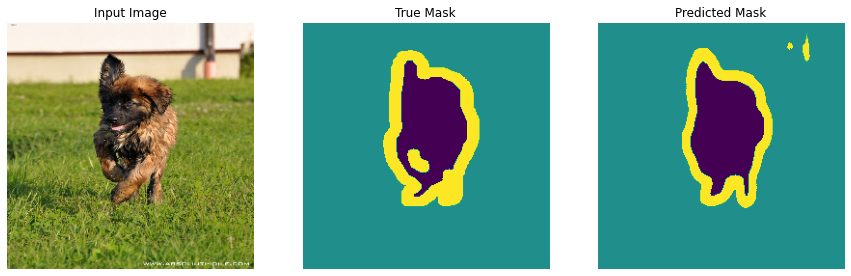

1/1 [==============================] - 0s 75ms/step


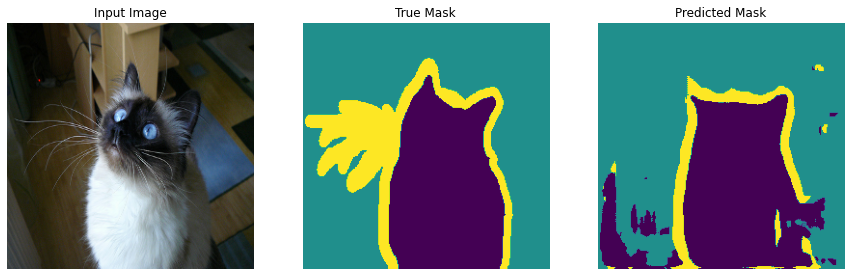

1/1 [==============================] - 0s 33ms/step


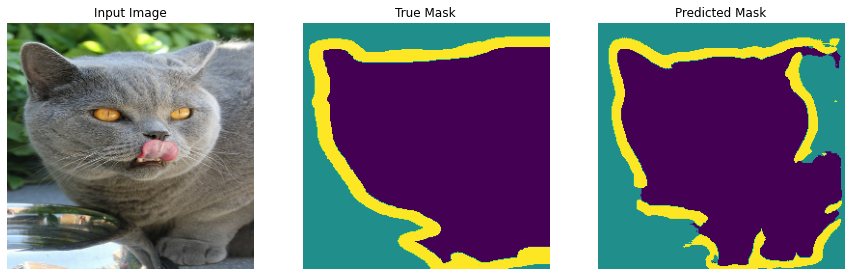

In [ ]:
show_predictions(test_batches, 3)

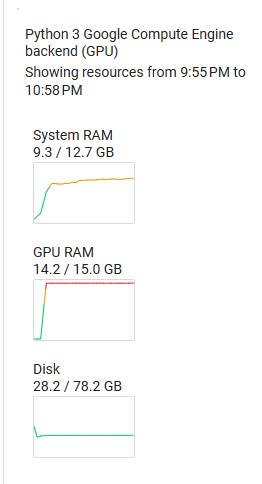

Due to memory constrainsts, I don't think I can go much further. However, the model did train well constantly with decreasing loss and increasing accuracy, albeit quite slowly.

I am reading DeepLabv3+ paper, it is taking some time to understand it.

In [ ]:
!mkdir -p saved_model
model.save('saved_model/my_model')

In [ ]:
!ls saved_model
!ls saved_model/my_model

my_model
assets	fingerprint.pb	keras_metadata.pb  saved_model.pb  variables


In [ ]:
import tensorflow as tf
import matplotlib.pyplot as plt

new_model = tf.keras.models.load_model('saved_model/my_model')
new_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 256, 256, 64  1792        ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 dropout (Dropout)              (None, 256, 256, 64  0           ['conv2d[0][0]']                 
                                )                                                             

Just checked if saved model gets loaded or not after using new gpu